In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import time
import cv2
import random
from microbump_generator import CT_scan, bump_test
from torch.utils.data import Dataset, DataLoader
from BumpNet import ViTNet
from VT_explanation_generator import LRP

cuda:0


In [2]:
def resistance_prediction(model, structure):
    structure = torch.from_numpy(structure.reshape(1, 1, 64, 64, 64)).type(torch.cuda.FloatTensor)
    model.to('cuda')
    model.eval()
    pred = model(structure)
    return pred.cpu().detach().numpy().reshape(-1, 1)
    
    
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
K = np.array([[[1,1,1],[1,0,1],[1,1,1]],[[1,0,1],[0,0,0],[1,0,1]],[[1,1,1],[1,0,1],[1,1,1]]])
def growth(bump, volumn=16000):
    boundary = []
    for v in range(volumn):
        if v==0:
            site = np.where(bump==0.75)
            for s in range(len(site[0])):
                x, y, z = site[0][s], site[1][s], site[2][s]
                if (0 in (bump[x-1:x+2, y-1:y+2, z-1:z+2].copy()+K)):
                    boundary.append([x, y, z])
        site = boundary[random.randint(0, len(boundary)-1)]
        x, y, z = site
        growth_site = np.where((bump[x-1:x+2, y-1:y+2, z-1:z+2].copy()+K)==0)
        if len(growth_site[0])==1:
            r=0
        else:
            r = random.randint(0, len(growth_site[0])-1)
        x1, y1, z1 = growth_site[0][r], growth_site[1][r], growth_site[2][r]
        boundary.append([x+x1-1, y+y1-1, z+z1-1])
        bump[x+x1-1, y+y1-1, z+z1-1] = 0.75
        cor = [x+x1-1, y+y1-1, z+z1-1]
        for i in range(3):
            for j in range(3):
                cor_ = cor.copy()
                cor_[i] += (j-1)
                x2, y2, z2 = cor_
                if (0 not in (bump[x2-1:x2+2, y2-1:y2+2, z2-1:z2+2].copy()+K)):
                    try:
                        boundary.remove([x2, y2, z2])
                    except ValueError:
                        continue
    return bump

# model = torch.load('bump_hybrid_aug.pth')
# test_data = CT_scan(train=False)
# pred, min_bump = 0, 100
# img = test_data[40][0].cpu().detach().numpy().reshape(64, 64, 64)
# for i in range(64):
#     g = img[:, :, i].copy()
#     img[:, :, i] = cv2.medianBlur(g, 3)
#     img[img<0.3] = 0
#     mid = img[:, 9:54, :].copy()
#     mid[mid<=0.5] = 0
#     mid[mid>0.7] = 0
#     img[:, 9:54, :] = mid.copy()
#     img[:, 25:37, :] = 0
# for i in range(24):
#     mask = create_circular_mask(64, 64, radius=5)
#     masked = img[:, 19+i, :].copy()
#     outside = img[:, 19+i, :].copy()
#     outside[mask] = 0
#     masked[~mask] = 1e-4
#     masked[masked==0] = 0.75
#     img[:, 19+i, :] = masked + outside
# img[img==1e-4] = 0
# resistance = []
# count_h, count_l = 0, 0
# for i in range(500):
#     bump = growth(img.copy())
#     for i in range(64):
#         g = bump[:, :, i].copy()
#         bump[:, :, i] = cv2.medianBlur(g, 3)
#     pred = resistance_prediction(model, bump)[0, 0]
#     print(pred)
#     resistance.append(pred)
#     if pred > 2.5:
#         plt.imshow(bump[:, :,32], cmap='gray', vmax=1)
#         plt.show()
#         plt.close()
#         np.save('bumps/high'+str(count_h)+'.npy', bump)
#         count_h+=1
#     elif pred < 0.5:
#         plt.imshow(bump[:, :,32], cmap='gray', vmax=1)
#         plt.show()
#         plt.close()
#         np.save('bumps/low'+str(count_l)+'.npy', bump)
#         count_l+=1
# plt.hist(resistance)
# plt.xlabel('Resistance', fontsize=18)
# plt.ylabel('num. of microbumps', fontsize=18)
# plt.title('Resistance Distribution', fontsize=20)

12984


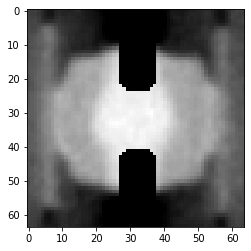

12360


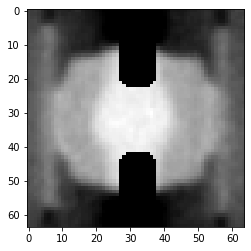

11600


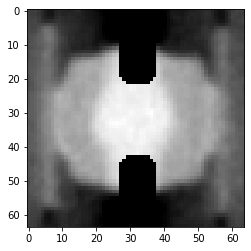

10836


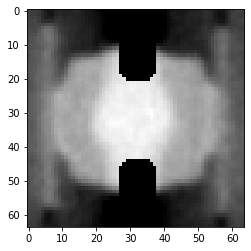

9980


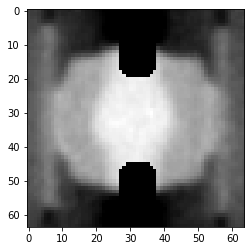

9020


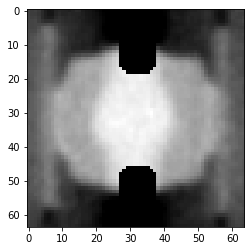

8032


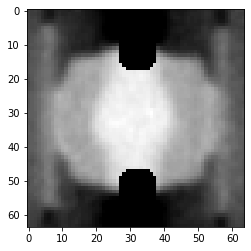

6968


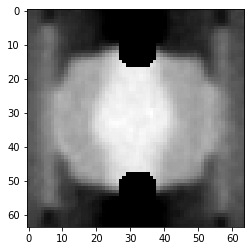

5816


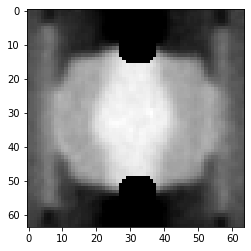

4633


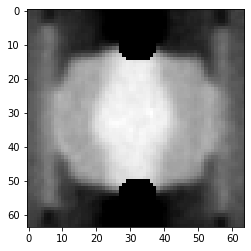

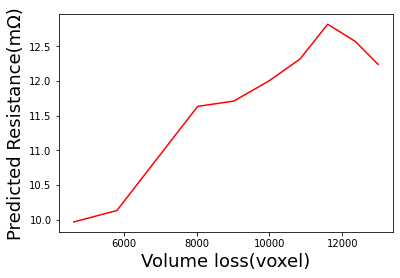

In [3]:
def show_cam_on_image(img, mask):
    mask[mask<0.1] = 0
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_HOT)
    heatmap = np.float32(heatmap) / 255
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cam = heatmap + np.float32(img)
    return cam


def relevance_map(attribution_generator, original_image, class_index=None):
    original_image = torch.from_numpy(original_image.reshape(1, 1, 64, 64, 64)).type(torch.cuda.FloatTensor)
    transformer_attribution = attribution_generator.generate_LRP(original_image, method="transformer_attribution",mode=1, output=1).detach()
    transformer_attribution = transformer_attribution.reshape(64, 64, 64).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.reshape(64, 64, 64).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = np.empty((64, 64, 64, 3))
    for i in range(64):
        vis[i, :, :, :] = show_cam_on_image(image_transformer_attribution[:,:,i], transformer_attribution[:,:,i])
    vis = vis/vis.max()
    for i in range(64):
        v = vis[i, :, :, :]
        v =  np.uint8(255 * v)
        v = cv2.cvtColor(np.array(v), cv2.COLOR_RGB2BGR)
        plt.imshow(v)
        plt.savefig('relevance_VT/'+str(i+1))
        plt.show()
        plt.close()

model = torch.load('bump_hybrid_aug.pth')
test_data = CT_scan(train=False)
pred, v = [], []
img = test_data[124][0].cpu().detach().numpy().reshape(64, 64, 64)
np.save('sample124', img)


for s in range(10):
    width = 12
    s = s+8
    remain = (64-width)//2
    new_img = img.copy()
    volumn_loss = 0
    for i in range(12):
        if i == 0:
            mask = np.ones((64, 64), dtype=bool)
        else:
            mask = create_circular_mask(64, 64, radius=(s+(width//2))-np.sqrt(np.abs((width//2)**2-((width//2)-i)**2)))
        masked = new_img[:, remain+i, :].copy()
        masked[~mask] = 0
        volumn = new_img[:, remain+i, :].copy()-masked
        volumn_loss += np.sum(volumn>0.5)
        new_img[:, remain+i, :] = masked
    v.append(volumn_loss)
    pred.append(resistance_prediction(model, new_img)[0, 0])
    print(volumn_loss)
    plt.imshow(new_img[:, :, 32], cmap='gray')
    plt.show()
    plt.close()
mean, sigma = 0.01411727, np.sqrt(7.34240751e-07)
plt.plot(v, ((np.array(pred)*sigma)+mean)/1.5*1000, c='red')
plt.xlabel('Volume loss(voxel)', fontsize=18)
plt.ylabel('Predicted Resistance(mΩ)', fontsize=18)
plt.show()
plt.close()

# heatmap = np.zeros((3, 3))
# for mode in range(3):
#     volumn_loss = 0
#     new_img = img.copy()
#     width = 12
#     if mode == 2:
#         width = 10
#     remain = (64-width)//2
#     for i in range(width):
#         if mode == 0:
#             if i<(width/2):
#                 mask = create_circular_mask(64, 64, radius=22-16/(width/2-1)*(i))
#             else:
#                 mask = create_circular_mask(64, 64, radius=22-16/(width/2-1)*((width-1)-i))
#         if mode == 1:
#             mask = create_circular_mask(64, 64, radius=22-12*np.sin(np.pi/width*i))
#         if mode == 2:
#             if i == 0:
#                 mask = np.ones((64, 64), dtype=bool)
#             else:
#                 mask = create_circular_mask(64, 64, radius=(11+(width//2))-np.sqrt(np.abs((width//2)**2-((width//2)-i)**2)))
#         masked = new_img[:, remain+i, :].copy()
#         masked[~mask] = 0
#         volumn = new_img[:, remain+i, :].copy()-masked
#         volumn_loss += np.sum(volumn>0.5)
#         new_img[:, remain+i-1, :] = masked
#     heatmap[mode,2] = resistance_prediction(model, new_img)[0, 0]
#     if mode==0:
#         lrp = LRP(model.to('cuda'))
#         relevance_map(lrp, new_img, resistance_prediction(model, new_img)[0, 0])
# for mode in range(3):
#     volumn_loss = 0
#     new_img = img.copy()
#     width = 12
#     remain = (64-width)//2
#     for i in range(width):
#         if mode == 0:
#             if i<(width/2):
#                 mask = create_circular_mask(64, 64, radius=22-14/(width/2-1)*(i))
#             else:
#                 mask = create_circular_mask(64, 64, radius=22-14/(width/2-1)*((width-1)-i))
#         if mode == 1:
#             mask = create_circular_mask(64, 64, radius=22-11*np.sin(np.pi/width*i))
#         if mode == 2:
#             if i == 0:
#                 mask = np.ones((64, 64), dtype=bool)
#             else:
#                 mask = create_circular_mask(64, 64, radius=(14+(width//2))-np.sqrt(np.abs((width//2)**2-((width//2)-i)**2)))
#         masked = new_img[:, remain+i, :].copy()
#         masked[~mask] = 0
#         volumn = new_img[:, remain+i, :].copy()-masked
#         volumn_loss += np.sum(volumn>0.5)
#         new_img[:, remain+i-1, :] = masked
# #     print(volumn_loss)
# #     plt.imshow(new_img[:, :, 32], cmap='gray')
# #     plt.show()
# #     plt.close()
#     heatmap[mode,1] = resistance_prediction(model, new_img)[0, 0]
    
# for mode in range(3):
#     volumn_loss = 0
#     new_img = img.copy()
#     width = 12
#     remain = (64-width)//2
#     for i in range(width):
#         if mode == 0:
#             if i<(width/2):
#                 mask = create_circular_mask(64, 64, radius=22-10/(width/2-1)*(i))
#             else:
#                 mask = create_circular_mask(64, 64, radius=22-10/(width/2-1)*((width-1)-i))
#         if mode == 1:
#             mask = create_circular_mask(64, 64, radius=22-8*np.sin(np.pi/width*i))
#         if mode == 2:
#             if i == 0:
#                 mask = np.ones((64, 64), dtype=bool)
#             else:
#                 mask = create_circular_mask(64, 64, radius=(16+(width//2))-np.sqrt(np.abs((width//2)**2-((width//2)-i)**2)))
#         masked = new_img[:, remain+i, :].copy()
#         masked[~mask] = 0
#         volumn = new_img[:, remain+i, :].copy()-masked
#         volumn_loss += np.sum(volumn>0.5)
#         new_img[:, remain+i-1, :] = masked
#     heatmap[mode,0] = resistance_prediction(model, new_img)[0, 0]
    
# plt.imshow(heatmap, cmap='hot')
# plt.xlabel('Volume Loss(↑)', fontsize=18)
# plt.yticks([0, 1, 2], ['Triangle', 'Sine', 'Round'], fontsize=14)
# plt.colorbar()
# plt.show()